# EE634 Intro to Neural Networks
# Assignment #4: Data Augmentation
# Zachary Chou
## Fall 2023

In [2]:
# Import libraries 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.datasets import cifar10
from keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models 
import tensorflow as tf
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt

In [19]:
!pip install opencv-python

     ---------------------------------------- 38.1/38.1 MB 4.0 MB/s eta 0:00:00


In [3]:
import cv2

In [64]:
# Avoid kernel crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
# Load dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [79]:
# Checking the images dimensions
display(train_images.shape)
display(test_images.shape)

(50000, 32, 32, 3)

(10000, 32, 32, 3)

# Baseline CNN

In [132]:
# Pre-process the data before undergoing CNN 
# And normalize pixel values between 0 and 1
train_images = train_images.reshape(50000, 32, 32, 3)
test_images = test_images.reshape(10000, 32, 32, 3)

train_images = train_images / 255.0
test_images = test_images/255.0

In [9]:
# Building the CNN model and compiling to run it  
def create_model():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model 
model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [10]:
# Showing epoch history
history = model.fit(train_images, train_labels, epochs=6, batch_size=32, validation_split=0.2)

# The number of epochs is choosen since each epoch takes a little longer
# than usual to process 
# the batch size is choosen since it provides smaller computation time and
# reduce overfitting
# the validation split is used to siginify how much of the data will be 
# split into training and testing data

Epoch 1/6
1250/1250 [==============================] - 22s 17ms/step - loss: 1.4915 - accuracy: 0.4624 - val_loss: 1.2406 - val_accuracy: 0.5685
Epoch 2/6
1250/1250 [==============================] - 23s 18ms/step - loss: 1.1342 - accuracy: 0.6015 - val_loss: 1.0739 - val_accuracy: 0.6209
Epoch 3/6
1250/1250 [==============================] - 23s 18ms/step - loss: 0.9992 - accuracy: 0.6510 - val_loss: 1.0554 - val_accuracy: 0.6307
Epoch 4/6
1250/1250 [==============================] - 21s 17ms/step - loss: 0.9022 - accuracy: 0.6852 - val_loss: 0.9781 - val_accuracy: 0.6639
Epoch 5/6
1250/1250 [==============================] - 20s 16ms/step - loss: 0.8203 - accuracy: 0.7136 - val_loss: 0.9536 - val_accuracy: 0.6737
Epoch 6/6
1250/1250 [==============================] - 21s 17ms/step - loss: 0.7485 - accuracy: 0.7401 - val_loss: 0.9471 - val_accuracy: 0.6753


In [96]:
# Save original CNN
model.save('CNN')

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


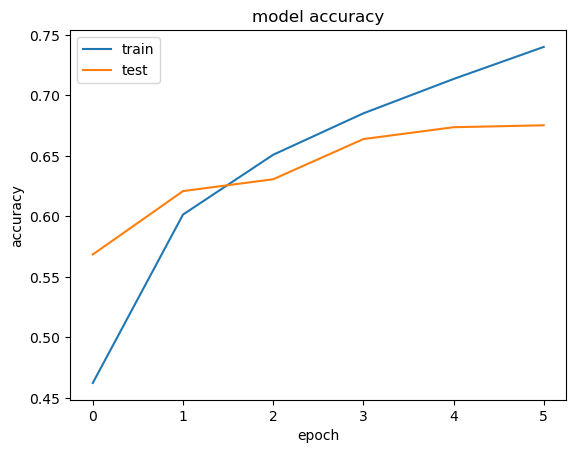

In [11]:
# Model accuracy as a plot for the train and test
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

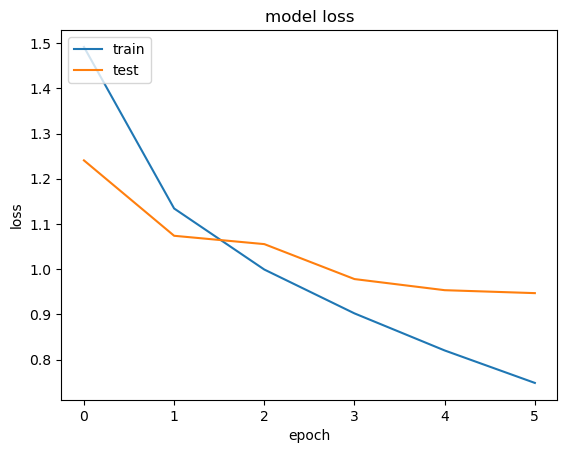

In [12]:
# Model loss over epochs as a plot for the train and test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# Evaluate the model's performance on the test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

predictions = model.predict (test_images)
print(predictions.shape, test_labels.shape)

313/313 [==============================] - 2s 5ms/step - loss: 0.9454 - accuracy: 0.6765
Test Loss: 0.9453967809677124
Test Accuracy: 0.6765000224113464
313/313 [==============================] - 2s 5ms/step
(10000, 10) (10000, 1)


In [14]:
# Show the confusion matrix
cm = confusion_matrix(test_labels, np.argmax(predictions, axis=1))
print(cm)

[[772  34  47  27  18  13   6   9  28  46]
 [ 21 825   5   8   3   5  10   2   9 112]
 [ 65   8 555  82  84  84  72  22   9  19]
 [ 14  17  88 533  63 170  47  32  11  25]
 [ 28  10  94  75 600  47  58  78   4   6]
 [ 19   5  73 201  41 571  25  52   3  10]
 [  4   9  51  89  34  30 768   4   5   6]
 [ 19   6  36  43  61  85  10 706   2  32]
 [147  82  19  18  13   8   4   5 648  56]
 [ 25 109  10  25   7   9   4  14  10 787]]


In [15]:
# Show the classification report
cr = classification_report(test_labels, np.argmax(predictions, axis=1))
print(cr)

              precision    recall  f1-score   support

           0       0.69      0.77      0.73      1000
           1       0.75      0.82      0.78      1000
           2       0.57      0.56      0.56      1000
           3       0.48      0.53      0.51      1000
           4       0.65      0.60      0.62      1000
           5       0.56      0.57      0.56      1000
           6       0.76      0.77      0.77      1000
           7       0.76      0.71      0.73      1000
           8       0.89      0.65      0.75      1000
           9       0.72      0.79      0.75      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



5000
[3, 10, 20, 28, 34, 58, 66, 82, 86, 89]
1/1 [==============================] - 0s 34ms/step


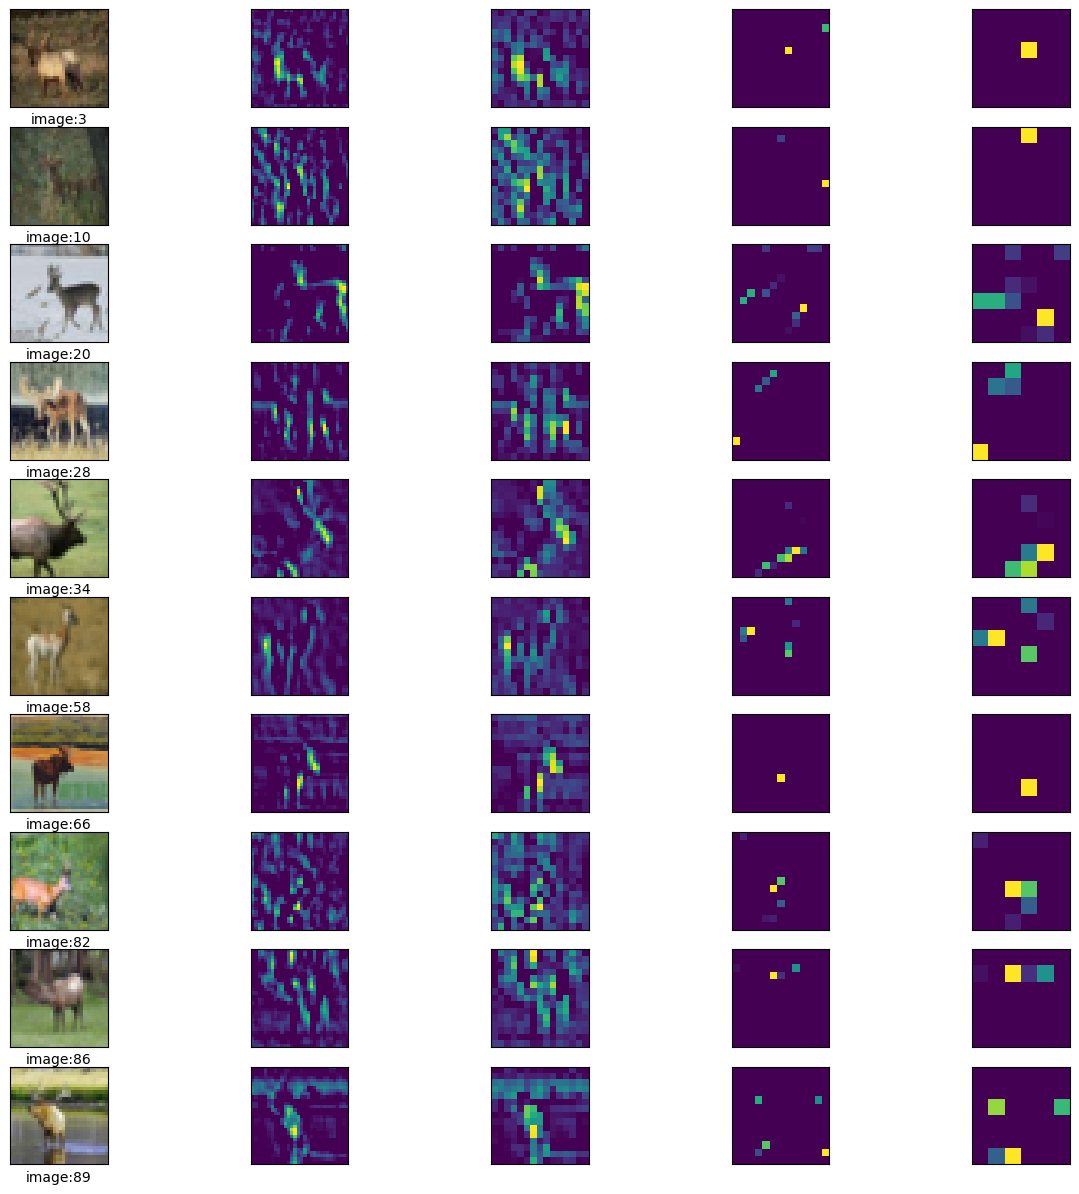

In [69]:
# Visualize feature maps - deer
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
deer_list = [i for i in range(len(train_images)) if train_labels[i] == 4]
print(len(deer_list))

print(deer_list[0:10])
train_labels[deer_list[0:10]]

np.argmax(model.predict(train_images[deer_list[0:10]]), axis=1)

f, ax = plt.subplots(10,5)
f.set_figheight(15)
f.set_figwidth(15)
plt.setp(ax, xticks=[], yticks=[])

for idx, k in enumerate(deer_list[0:10]):
    ax[idx,0].imshow(train_images[k], cmap='viridis')
    ax[idx,0].set_xlabel('image:'+str(k))
    for lay_ind in range(0,4):
        f = activation_model.predict(train_images[k].reshape(1, 32, 32, 3))[lay_ind]
        ax[idx,lay_ind+1].imshow(f[0, : , :, 1], cmap='viridis')

# CNN with data augmentation from disk

In [7]:
# Load the images into the folders 
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def save_images_from_dict(dict, root):
    data = dict[b'data']
    labels = dict[b'labels']
    filenames = dict[b'filenames']
    for i in range(len(filenames)):
        flat_image = data[i]
        image = np.reshape(flat_image, (3, 32, 32))
        image = np.transpose(image, (1, 2, 0))
        label = labels[i]
        filename = filenames[i].decode('utf-8')
        directory = os.path.join(root, str(label))
        if not os.path.exists(directory):
            os.makedirs(directory)
        filepath = os.path.join(directory, filename)
        im = Image.fromarray(image)
        im.save(filepath)

root = 'cifar-10-data'
batches_meta = unpickle('cifar-10-batches-py/batches.meta')
label_names = batches_meta[b'label_names']

for i in range(1, 6):
    batch_file = f'cifar-10-batches-py/data_batch_{i}'
    dict = unpickle(batch_file)
    save_images_from_dict(dict, os.path.join(root, 'train'))

test_batch_file = 'cifar-10-batches-py/test_batch'
dict = unpickle(test_batch_file)
save_images_from_dict(dict, os.path.join(root, 'test'))

KeyboardInterrupt: 

In [8]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Random rotation within 
    # 15 degrees
    width_shift_range=0.1,  # Random width shift 
    # up to 10%
    height_shift_range=0.1,  # Random height shift 
    # up to 10%
    horizontal_flip=True)  # Random horizontal flip

In [9]:
# Iterator for the training dataset 
train_generator = datagen.flow_from_directory(
    'cifar-10-data/train',
    target_size=(32, 32),
    batch_size=32,
    class_mode='sparse',
    subset='training')  # set as training data

Found 87953 images belonging to 21 classes.


In [ ]:
# Iterator for the validation dataset
valid_generator = datagen.flow_from_directory( 
    'cifar-10-data/train',
    target_size = (28, 28),
    batch_size=32,
    subset = 'validation',
    shuffle = True,
    seed = 97
)

In [ ]:
# Iterator for the testing dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'cifar-10-data/test',
    target_size=(32, 32),
    batch_size=32,
    class_mode='sparse')

In [ ]:
# Building the CNN model and compiling to run it  
def create_model():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax')
    ])
    return model 
model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(train_generator,
    validation_data = valid_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    epochs=5)

In [168]:
# Save disk CNN
model.save('Disk_CNN')

INFO:tensorflow:Assets written to: Disk_CNN\assets


INFO:tensorflow:Assets written to: Disk_CNN\assets


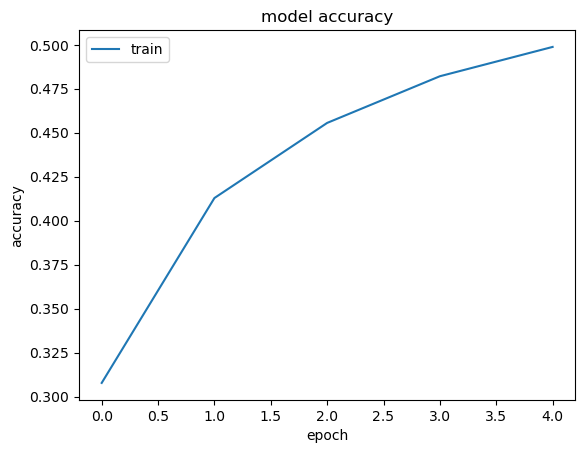

In [171]:
# Model accuracy as a plot for the train and test
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
# Model loss over epochs as a plot for the train and test
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [169]:
# Evaluate the "testing" data
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 123s 393ms/step - loss: 2.6535 - accuracy: 0.1000
Test loss: 2.653517246246338
Test accuracy: 0.10000000149011612


In [175]:
# Making predictions
predict = model.predict(test_generator)
y_predict = np.argmax(predictions,axis=1)

313/313 [==============================] - 14s 45ms/step


In [177]:
# Show the confusion matrix
y_true = test_generator.classes

cm = confusion_matrix(y_true,y_predict)

print(cm)

[[  0   0   0   0   0   0   0   0   0   0   0]
 [ 83  92  90  79  83  70 139 126 112 126   0]
 [ 90 108  88  72 108  76 109 112 107 130   0]
 [ 93  93 109  70 111  86 119 108 105 106   0]
 [ 84 111  99  61  99  87 118 121  92 128   0]
 [ 95 115  76  74 108  94 113 112  95 118   0]
 [ 97  93  83  71  98  92 140 132  72 122   0]
 [ 93  96 101  69 107  89 119 108  98 120   0]
 [ 94 101  96  72  98  92 113 117  92 125   0]
 [ 83  99  84  83  86  75 139 114 110 127   0]
 [103  91  76  68 104  77 111 134 101 135   0]]


In [178]:
# Show the classification report
cr = classification_report(y_true,y_predict)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.09      0.09      0.09      1000
           2       0.10      0.09      0.09      1000
           3       0.10      0.07      0.08      1000
           4       0.10      0.10      0.10      1000
           5       0.11      0.09      0.10      1000
           6       0.11      0.14      0.13      1000
           7       0.09      0.11      0.10      1000
           8       0.09      0.09      0.09      1000
           9       0.10      0.13      0.11      1000
          10       0.00      0.00      0.00      1000

    accuracy                           0.09     10000
   macro avg       0.08      0.08      0.08     10000
weighted avg       0.09      0.09      0.09     10000



C:\Users\choub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\choub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\choub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\choub\anaconda3\lib\site-packages\sklearn\metrics\_cla

# CNN with data augmentation from memory

In [97]:
# Load dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [98]:
# Pre-process the data before undergoing CNN 
# And normalize pixel values between 0 and 1
train_images = train_images.reshape(50000, 32, 32, 3)
test_images = test_images.reshape(10000, 32, 32, 3)

train_images = train_images / 255.0
test_images = test_images /255.0

In [99]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Random rotation within 15 degrees
    width_shift_range=0.1,  # Random width shift up to 10%
    height_shift_range=0.1,  # Random height shift up to 10%
    horizontal_flip=True)  # Random horizontal flip

# Fit the ImageDataGenerator to the training data
datagen.fit(train_images)

In [100]:
# Building the CNN model and compiling to run it  
def create_model():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model 
model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 2304)              0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [111]:
# Fitting the model to display the accuracy and loss values
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32, epochs=6)

Epoch 1/6
1562/1562 [==============================] - 45s 29ms/step - loss: 0.8302 - accuracy: 0.1015
Epoch 2/6
1562/1562 [==============================] - 67s 43ms/step - loss: 0.8207 - accuracy: 0.1014
Epoch 3/6
1562/1562 [==============================] - 65s 42ms/step - loss: 0.8073 - accuracy: 0.1015
Epoch 4/6
1562/1562 [==============================] - 47s 30ms/step - loss: 0.7963 - accuracy: 0.1000
Epoch 5/6
1562/1562 [==============================] - 46s 29ms/step - loss: 0.7827 - accuracy: 0.0999
Epoch 6/6
1562/1562 [==============================] - 60s 38ms/step - loss: 0.7716 - accuracy: 0.1016


In [112]:
# Save CNN from memory model
model.save('Memory_Model')

INFO:tensorflow:Assets written to: Memory_Model\assets


INFO:tensorflow:Assets written to: Memory_Model\assets


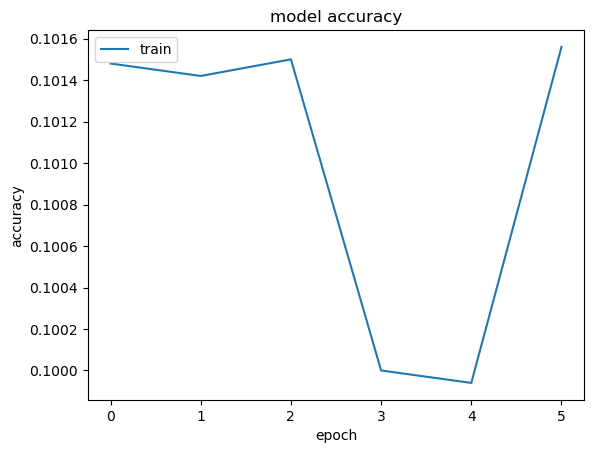

In [113]:
# Model accuracy as a plot for the train and test
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

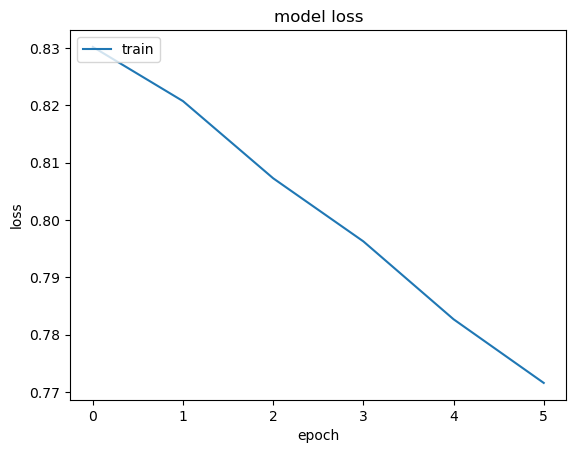

In [114]:
# Model loss over epochs as a plot for the train and test
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [115]:
# Evaluate the model's performance on the test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

predictions = model.predict (test_images)
print(predictions.shape, test_labels.shape)

313/313 [==============================] - 2s 6ms/step - loss: 0.7450 - accuracy: 0.0915
Test Loss: 0.744965136051178
Test Accuracy: 0.09149999916553497
313/313 [==============================] - 2s 5ms/step
(10000, 10) (10000, 1)


In [116]:
# Show the confusion matrix
cm = confusion_matrix(test_labels, np.argmax(predictions, axis=1))
print(cm)

[[739  22  57  12  18   6   7  16  47  76]
 [  8 860   4   2   2   2   8   2  12 100]
 [ 54   5 626  26  79  44  80  54  14  18]
 [ 15  14  65 470  68 123 117  66  18  44]
 [ 17   2  52  27 711  26  59  92   5   9]
 [  7   6  51 128  51 592  48  86  11  20]
 [  5   9  19  23  29  10 880  10   5  10]
 [  7   7  15  17  36  32  10 847   1  28]
 [ 45  18   7   9   4   2   4   4 855  52]
 [ 18  56   6   5   4   1   7   7  16 880]]


In [117]:
# Show the classification report
cr = classification_report(test_labels, np.argmax(predictions, axis=1))
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1000
           1       0.86      0.86      0.86      1000
           2       0.69      0.63      0.66      1000
           3       0.65      0.47      0.55      1000
           4       0.71      0.71      0.71      1000
           5       0.71      0.59      0.64      1000
           6       0.72      0.88      0.79      1000
           7       0.72      0.85      0.78      1000
           8       0.87      0.85      0.86      1000
           9       0.71      0.88      0.79      1000

    accuracy                           0.75     10000
   macro avg       0.74      0.75      0.74     10000
weighted avg       0.74      0.75      0.74     10000



# Visualization between the original and 
# augmentation for from disk

Found 5000 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.


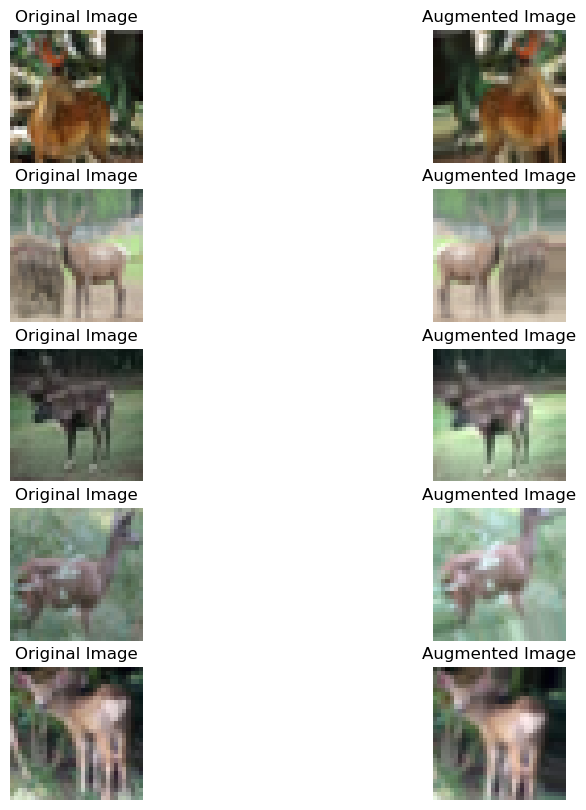

In [184]:
# Assuming you have a directory 'cifar-10-data/train' with subdirectories for each class
# and 'deer' is one of the subdirectories

# Define the directory and class
directory = 'cifar-10-data/train'
class_name = 'deer'

# Create a new ImageDataGenerator for the original images
datagen_original = ImageDataGenerator(rescale=1./255)

# Create a generator for the original images
original_generator = datagen_original.flow_from_directory(
    directory,
    classes=[class_name],
    target_size=(32, 32),
    batch_size=1,
    class_mode=None,
    seed=1)

# Create a generator for the augmented images
augmented_generator = datagen.flow_from_directory(
    directory,
    classes=[class_name],
    target_size=(32, 32),
    batch_size=1,
    class_mode=None,
    seed=1)

# Get the original and augmented images
original_images = [original_generator.next() for _ in range(5)]
augmented_images = [augmented_generator.next() for _ in range(5)]

# Normalize the images to the range [0, 1]
augmented_images = [img / np.amax(img) for img in augmented_images]

# Plot the original and augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    # Original image
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(original_images[i][0])
    plt.title('Original Image')
    plt.axis('off')

    # Augmented image
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(augmented_images[i][0])
    plt.title('Augmented Image')
    plt.axis('off')
plt.show()


# Visualization between the original and 
# augmentation for from memory

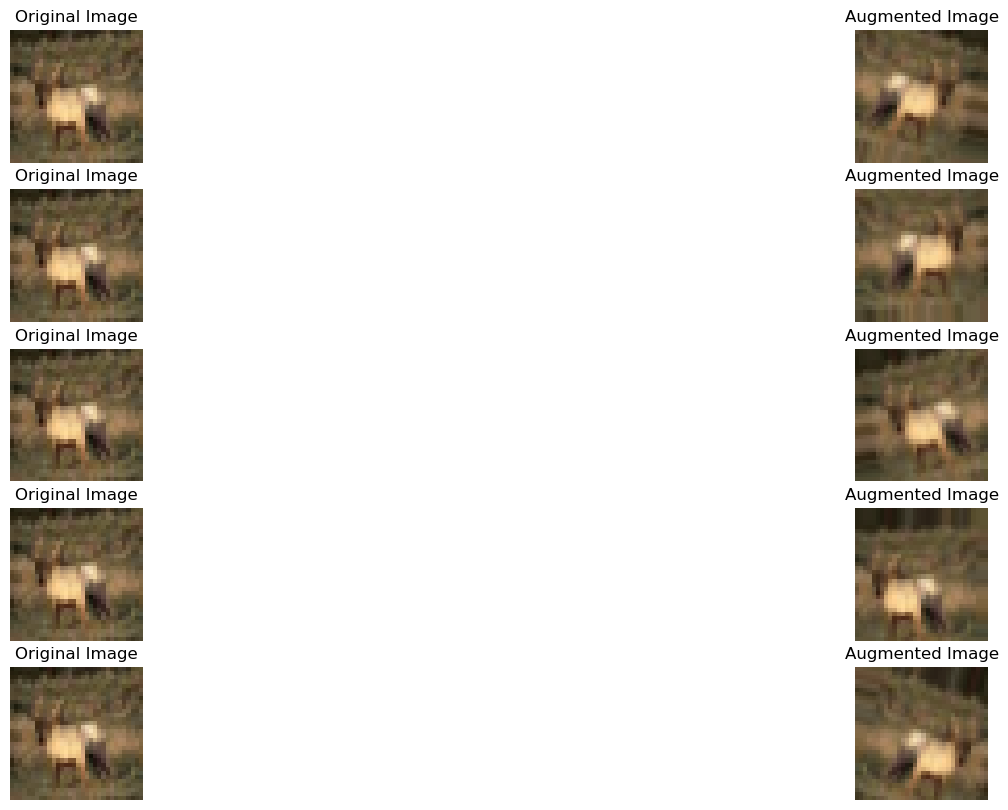

In [188]:
# Assuming train_labels is your labels
train_labels = train_labels

# Select an image from the "deer" class (label 4)
deer_indices = np.where(train_labels == 4)[0]  # Get the indices of "deer" images
deer_index = deer_indices[0]  # Select the first "deer" image
deer_image = train_images[deer_index]  # Get the "deer" image

# Generate augmented images
augmented_images = []  # Start with an empty list
original_images = [deer_image]  # Start with the original image
for _ in range(5):  # Generate 5 augmented images
    augmented_image = datagen.random_transform(deer_image)
    augmented_images.append(augmented_image)
    original_images.append(deer_image)  # Add the original image to the list

# Normalize the images to the range [0, 1]
normalized_images = [img / np.amax(augmented_image) for img in augmented_images]
normalized_originals = [img / np.amax(augmented_image) for img in original_images]

# Plot the original and augmented images
plt.figure(figsize=(20, 10))
for i in range(5):
    # Original image
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(normalized_originals[i])
    plt.title('Original Image')
    plt.axis('off')

    # Augmented image
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(normalized_images[i])
    plt.title('Augmented Image')
    plt.axis('off')
plt.show()


## DUE DATE: Monday, November 6, 2023